PS D:\MS Purdue\1\ECE570> python --version

Python 3.9.0

PS D:\MS Purdue\1\ECE570> py -3.11 --version

Python 3.11.9

py -3.11 -m pip list

py -3.11 -m pip install <package_name>

In [1]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import os
import torch.optim as optim
import torch.nn as nn


# Print the current working directory
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

c:\Users\alanc\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current directory: d:\MS Purdue\1\ECE570\Project\VaniilaNet-with_FC


In [2]:
# Path to dataset
data_dir = '../tiny-imagenet-200Class-500Data/'

transform4val = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

transform4train = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Load training and validation data with the new normalization
train_dataset = datasets.ImageFolder(root=data_dir + 'train', transform=transform4train)
val_dataset = datasets.ImageFolder(root=data_dir + 'val', transform=transform4val)

# DataLoader for batching
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Check class-to-index mapping and dataset sizes
print(train_dataset.class_to_idx)
print(f"Train subset size: {len(train_dataset)}")
print(f"Validation subset size: {len(val_dataset)}")

# Example: Iterate through the train_loader to test
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break


{'n01443537': 0, 'n01629819': 1, 'n01641577': 2, 'n01644900': 3, 'n01698640': 4, 'n01742172': 5, 'n01768244': 6, 'n01770393': 7, 'n01774384': 8, 'n01774750': 9, 'n01784675': 10, 'n01855672': 11, 'n01882714': 12, 'n01910747': 13, 'n01917289': 14, 'n01944390': 15, 'n01945685': 16, 'n01950731': 17, 'n01983481': 18, 'n01984695': 19, 'n02002724': 20, 'n02056570': 21, 'n02058221': 22, 'n02074367': 23, 'n02085620': 24, 'n02094433': 25, 'n02099601': 26, 'n02099712': 27, 'n02106662': 28, 'n02113799': 29, 'n02123045': 30, 'n02123394': 31, 'n02124075': 32, 'n02125311': 33, 'n02129165': 34, 'n02132136': 35, 'n02165456': 36, 'n02190166': 37, 'n02206856': 38, 'n02226429': 39, 'n02231487': 40, 'n02233338': 41, 'n02236044': 42, 'n02268443': 43, 'n02279972': 44, 'n02281406': 45, 'n02321529': 46, 'n02364673': 47, 'n02395406': 48, 'n02403003': 49, 'n02410509': 50, 'n02415577': 51, 'n02423022': 52, 'n02437312': 53, 'n02480495': 54, 'n02481823': 55, 'n02486410': 56, 'n02504458': 57, 'n02509815': 58, 'n0266

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].


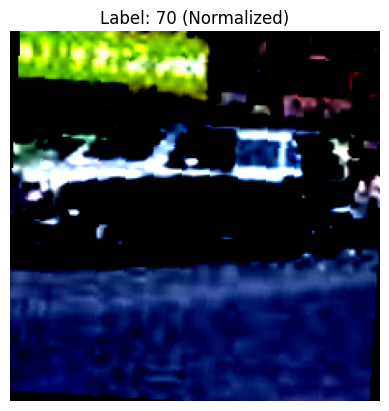

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Get a single batch of data
dataiter = iter(train_loader)
images, labels = dataiter.next()

# Select the first image from the batch (after normalization)
img = images[0]  # First image in the batch

# Convert the tensor to a numpy array for visualization
img = img.numpy().transpose((1, 2, 0))  # Change from (C, H, W) to (H, W, C) for matplotlib

# Plot the normalized image directly
plt.imshow(img)
plt.title(f'Label: {labels[0].item()} (Normalized)')
plt.axis('off')  # Turn off the axis
plt.show()


In [4]:
# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available

# Import the specific functions from the vanillanet.py file
from vanillanet_NN import vanillanet_5, vanillanet_6, vanillanet_9

# # Create an instance of the VanillaNet model (VanillaNet-9 in this case)
# model = vanillanet_9(pretrained=False, num_classes=200).to(device)  


class SimpleModifiedVanillaNet5(nn.Module):
    def __init__(self, num_classes=200):
        super(SimpleModifiedVanillaNet5, self).__init__()
        
        # Load the original VanillaNet-5 model
        self.features = vanillanet_5(pretrained=False, num_classes=512, deploy=False)
        
        # Remove the original classification layer
        self.features.cls = nn.Identity()
        
        # Add new FC layers
        self.fc_layers = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.5),         

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 200))

    def forward(self, x):
        x = self.features(x)
        x = self.fc_layers(x)
        return x
    
    def change_act(self, value):
        self.features.change_act(value)

    def switch_to_deploy(self):
        if not self.deploy:
            self.features.switch_to_deploy()
            self.deploy = True


model = SimpleModifiedVanillaNet5(num_classes=200).to(device)

# Print model architecture to verify
print(model)


SimpleModifiedVanillaNet5(
  (features): VanillaNet(
    (stem1): Sequential(
      (0): Conv2d(3, 512, kernel_size=(4, 4), stride=(4, 4))
      (1): BatchNorm2d(512, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True)
    )
    (stem2): Sequential(
      (0): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(512, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True)
      (2): activation(
        (bn): BatchNorm2d(512, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (stages): ModuleList(
      (0): Block(
        (conv1): Sequential(
          (0): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(512, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv2): Sequential(
          (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(1024, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True)
        )
 

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt  # For plotting

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-6)  # lr=0.1, weight_decay=1e-3. before, lr=0.01 without weight decay.

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10000  # Number of epochs
patience = 5  # Patience for early stopping
best_val_loss = float('inf')  # Initialize best validation loss as infinity
epochs_without_improvement = 0  # Counter for how many epochs passed without improvement

early_stop = False

# Initialize the learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',      # Reduce when the quantity monitored has stopped decreasing
                                                 factor=0.5,     # Factor by which the learning rate will be reduced
                                                 patience=1,     # Number of epochs with no improvement after which learning rate will be reduced
                                                 verbose=True)   # Print a message when the learning rate is reduced

for epoch in range(num_epochs):
    if early_stop:
        print("Early stopping triggered.")
        break

    # Update act_learn
    act_learn = 1 - (epoch / num_epochs)
    model.change_act(act_learn)
    
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy
    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()  # Set model to evaluation mode
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():  # No need to calculate gradients during validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Step the scheduler
    scheduler.step(avg_val_loss)  # Update the learning rate based on validation loss


    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Validation Accuracy: {val_accuracy:.2f}%, Validation Loss: {avg_val_loss:.4f}')

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss  # Update the best validation loss
        epochs_without_improvement = 0  # Reset the counter if we have improvement
        best_model_wts = model.state_dict()  # Optionally save the best model
    else:
        epochs_without_improvement += 1  # Increment the counter

    if epochs_without_improvement >= patience:
        print(f'Early stopping after {epoch+1} epochs without improvement.')
        early_stop = True
        # load the best model weights
        model.load_state_dict(best_model_wts)

print('Training complete!')

model.switch_to_deploy()

# Plotting the results
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Save the model with the best performance
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)  # Ensure we load the best model weights before saving
    torch.save(model.state_dict(), 'best_model.pth')  # Save model to a file
    print("Best model saved as 'best_model.pth'")
else:
    print("No improvement in validation loss, model not saved.")

Epoch [1/10000], Train Loss: 5.0865, Train Accuracy: 1.79%
Validation Accuracy: 3.39%, Validation Loss: 4.8413
Epoch [2/10000], Train Loss: 4.7483, Train Accuracy: 3.95%
Validation Accuracy: 6.01%, Validation Loss: 4.4630
Epoch [3/10000], Train Loss: 4.5419, Train Accuracy: 5.20%
Validation Accuracy: 6.76%, Validation Loss: 4.3347
